In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

LOAD THE DATASET, PREPARE THE DATASET

use the mnist dataset to train the generator and the discriminator  

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")

# normalize the images to the range [-1, 1]
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256 

# batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


CREATE THE GENERATOR

this generator will use Conv2DTranspose (upsampling) layers to produce an image from random noise.

start with a dense layer that takes a seed as input, then upsample several times until the desired image size of 28 * 28 *1

important to note the activation function for each layer is 'leakyRelU' whilst in the layer it is "tanh" 

In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None, 7, 7, 256) # None is the batch size

    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model



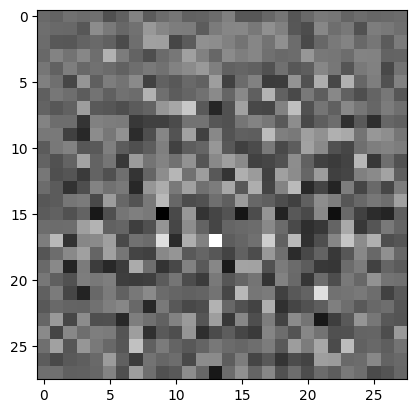

In [4]:
# use the generator to create an image

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training = False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

CREATE THE DISCRIMINATOR

the discriminator is a CNN image classifier

In [5]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides = (2, 2), padding = 'same', input_shape = [28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides = (2, 2), padding = 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model 



use the discriminator ( as yet untrained) to classify the generated image as real or fake.

the model will be trained to return positive values for real images and negative values for fake images

In [6]:
discriminator = make_discriminator_model()

decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00054159]], shape=(1, 1), dtype=float32)


DEFINE THE LOSS AND OPTIMIZERS

define loss functions and optimizers for both models

In [7]:
# this method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [8]:
# discriminator loss, this method quantifies how well the discriminator is able to distinguish real imges from fake images.

# it compares the discriminators predictions on real images to an array of one's and the discrimintors
# predictions on fake (generated images) to an array of zero's

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [9]:
# generator loss, this will quantify how well the generator tricks the discriminator.

# if the generator is performing well, the discriminator will classify the fake images as real (or 1).

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [10]:
# the generator and discriminator optimizers are different since you train two networks separately
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
# save checkpoints
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                    discriminator_optimizer = discriminator_optimizer,
                                    generator = generator,
                                    discriminator = discriminator)

In [12]:
# DEFINE THE TRAINING LOOP

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

the training loop begins with a generator receiving a random seed as input. that seed is used to produce an image. 

the discriminator is then used to classify real images (drawn from the training set) and fake images (produced by the generator.)

the loss is calculated for each of these model sand the gradients are used to update the generator and discriminator 

In [13]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [14]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print(f"Time for epoch {epoch + 1} is {time.time() - start} sec")

        # generate after the final epoch
        display.clear_output(wait = True)
        generate_and_save_images(generator, epochs, seed)
       

In [15]:
# generate and save images

!mkdir images

def generate_and_save_images(model, epoch, test_input):
    # training is set to false, this is so all layers run in inference mode (batchnorm)

    predictions = model(test_input, training = False)

    fig = plt.figure(figsize = (4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'images/image_at_epoch_{epoch:04d}.png')
    plt.show()

In [17]:
train(train_dataset, EPOCHS)

KeyboardInterrupt: 

In [18]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [23]:
def display_images(epoch_no):
    return PIL.Image.open(f"images/image_at_epoch_{epoch_no:04d}.png")

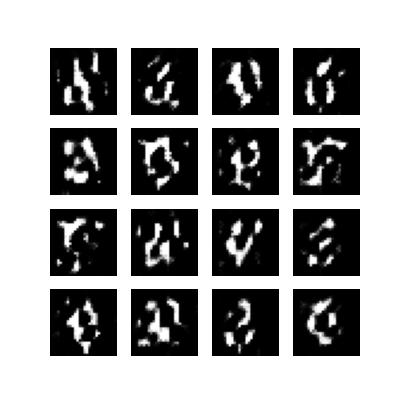

In [24]:
display_images(EPOCHS)

use imageio to create an animted gif using the images saved during training

In [26]:
anim_file = "dcgan.gif"

with imageio.get_writer(anim_file, mode = "I") as writer:
    filenames = glob.glob("images/image*.png")
    filenames = sorted(filenames)

    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    
    image = imageio.imread(filename)
    writer.append_data(image)

C:\Users\n036624\AppData\Local\Temp\ipykernel_8680\3889596240.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\n036624\AppData\Local\Temp\ipykernel_8680\3889596240.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [27]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

ModuleNotFoundError: No module named 'tensorflow_docs'